In [1]:
import crispr_assembler as ca
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

%load_ext autoreload
%autoreload 2

import pickle

In [2]:
def process_path(path, cut = -1, save = 1):
    pairs_path = path + "/out/pairs/"
    files = sorted(os.listdir(pairs_path))
    
    print(pairs_path + files[0])
    
    read = ca.Read(pairs_path + files[0])
    read.correct_errors(minimum_occurences=5)
    gr = read.graph_from_pairs()[0]
    
    print('calc embs')
    ec = ca.EmbeddingsCalculator()
    ec.make_argsorts(gr[:cut, :cut])
    embs = ec.fit_predict(gr[:cut, :cut], njobs=32)
    
    if save:
        pickle.dump(read, open(path + "/read", 'wb'))
        np.save(path + "/graph", gr)
        np.save(path + "/embs", embs)
        
    return read, gr, embs

In [3]:
def load(path):
    return pickle.load(open(path + "/read", 'rb')), np.load(path + "/graph.npy"), np.load(path + "/embs.npy")

In [4]:
def unwrap_idx_to_spacer(idx_to_spacer):
    values_as_list = []
    for i in range(len(idx_to_spacer)):
        values_as_list.append(idx_to_spacer[i])
    return values_as_list

In [5]:
def continue_steps(reads, pointers):
    return any([pointers[i] < len(reads[i]) for i in range(len(reads))])

In [6]:
def merge_reads(reads, t=1, v = 1):
    spacers_lists = [unwrap_idx_to_spacer(x) for x in reads]#[unwrap_idx_to_spacer(x.index_to_cluster) for x in reads]
    pointers = [0 for i in range(len(reads))]
    merged_sp_to_idxes = {}
    old_idx_to_new_idx = [{} for i in range(len(reads))]
    
    curr = 0
    while continue_steps(spacers_lists, pointers):
        for i in range(len(reads)):
            if pointers[i] < len(reads[i]):
                spacer = spacers_lists[i][pointers[i]]
                
                dist, closest = ca.find_closest(merged_sp_to_idxes, spacer)
                if dist > t:
                    merged_sp_to_idxes[spacer] = curr
                    #new_sp_to_ids[i][spacer] = curr
                    old_idx_to_new_idx[i][pointers[i]] = curr
                    curr += 1
                else:
                    old_idx_to_new_idx[i][pointers[i]] = merged_sp_to_idxes[closest]
                
                pointers[i] += 1
                
                if curr % 100 == 0:
                    print(curr)
                

                if v:
                    print(i, pointers[i], spacer, dist, merged_sp_to_idxes)#, new_sp_to_ids[1])
                    
    return merged_sp_to_idxes,  old_idx_to_new_idx

In [7]:
def rearange(gr, order):
    new_gr = np.zeros((max(order.values()) + 1, max(order.values()) + 1))

    for i in tqdm.tqdm(range(len(order.keys()))):
        for j in range(len(order.keys())):
            new_gr[order[i], order[j]] = gr[i, j]

    return new_gr

In [8]:
read_slv, gr_slv, emb_slv = process_path("../../data/environmental/slo2/")

../../data/environmental/slo2//out/pairs/SlO2_ACTGAT_L001_R1_001.fastq.gz_pairs.txt


100%|██████████| 1065/1065 [00:01<00:00, 977.95it/s] 


calc embs


In [9]:
#answer_sensivity = ca.read_arrays_with_tags("../../article/data/answers/sensivity", 0)
answer = ca.read_arrays_with_tags("../../article/data/answers/all", 0)

In [10]:
a, d = ca.multiple_arrays_to_ids(answer, read_slv.spacer_to_cluster_index)

#a_all, d_all = ca.multiple_arrays_to_ids(answer_all, res.spacer_to_cluster_index)

answ_gr = ca.graph_from_arrays([x for x in a.values()], gr_slv.shape[0])[0]

100%|██████████| 54/54 [00:01<00:00, 38.99it/s]


In [22]:
a

{'first_1': [134, 425, 187, 589, 42, 384, 0],
 'first_11': [134, 425, 187, 589, 42, 384, 0],
 'first_2': [32, 586, 80, 250, 320],
 'first_24': [32, 586, 80, 250, 320],
 'first_61': [32, 586, 80, 250, 320],
 'first_62': [32, 586, 80, 250, 320],
 'first_68': [32, 586, 80, 250, 320],
 'first_3': [250, 320, 556, 181, 312, 4, 422],
 'first_5': [68, 6, 5, 10, 334, 338, 12, 9, 15, 8, 13],
 'first_50': [68, 6, 5, 10, 334, 338, 12, 9, 15, 8, 13],
 'first_7': [0, 373, 206, 545, 193, 581, 431, 355, 132],
 'first_8': [68, 6, 5, 338, 12, 9, 15, 8, 13, 11, 14, 38],
 'first_14': [85, 22, 72, 219, 225, 139, 326, 118, 51, 485, 274, 579],
 'first_15': [134,
  425,
  187,
  430,
  589,
  42,
  475,
  465,
  84,
  259,
  384,
  0,
  398,
  360,
  563,
  126,
  386,
  433,
  27],
 'first_19': [85, 22, 72, 219, 225, 139, 51, 177],
 'first_20': [85, 22, 72, 219, 225, 139, 51, 177],
 'first_22': [85, 22, 72, 219, 225, 139, 51, 177],
 'first_31': [85, 22, 72, 219, 225, 139, 51, 177],
 'first_21': [32, 308, 599

In [11]:
d

{'first_1': [0, 0, 0, 13, 13, 0, 13],
 'first_11': [0, 0, 0, 13, 13, 0, 13],
 'first_2': [2, 2, 2, 2, 2],
 'first_24': [2, 2, 2, 2, 2],
 'first_61': [2, 2, 2, 2, 2],
 'first_62': [2, 2, 2, 2, 2],
 'first_68': [2, 2, 2, 2, 2],
 'first_3': [1, 1, 1, 12, 12, 13, 13],
 'first_5': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'first_50': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'first_7': [12, 1, 12, 2, 12, 13, 13, 13, 13],
 'first_8': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'first_14': [0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0],
 'first_15': [0, 0, 0, 0, 13, 13, 0, 12, 14, 0, 0, 13, 0, 0, 0, 0, 0, 0, 14],
 'first_19': [0, 0, 0, 0, 0, 0, 0, 0],
 'first_20': [0, 0, 0, 0, 0, 0, 0, 0],
 'first_22': [0, 0, 0, 0, 0, 0, 0, 0],
 'first_31': [0, 0, 0, 0, 0, 0, 0, 0],
 'first_21': [0, 0, 12, 13, 13, 0, 14, 0, 0, 12, 13],
 'first_23': [0, 0, 12, 13, 13, 0, 14, 0, 0, 12, 13],
 'first_27': [0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 14, 13, 14],
 'first_65': [0, 0, 12, 13, 13, 0, 14, 0, 0, 12],
 'first_70': [0, 0, 12, 13, 13, 0, 14

In [12]:
arrays_found_d = []
for k,v in d.items():
    if max(sorted(v)[::-1][:]) < 3:
        arrays_found_d.append(k)

In [13]:
arrays_found_v = []
for k,v in a.items():
    #print(k, sorted(v)[::-1])
    if max(sorted(v)[::-1][1:]) < 300:
        arrays_found_v.append(k)

In [14]:
arrays_found_d

['first_2',
 'first_24',
 'first_61',
 'first_62',
 'first_68',
 'first_5',
 'first_50',
 'first_8',
 'first_19',
 'first_20',
 'first_22',
 'first_31',
 'first_9',
 'first_66',
 'second_1',
 'second_11',
 'second_67']

In [15]:
set(arrays_found_v).intersection(set(arrays_found_d))

{'first_19',
 'first_20',
 'first_22',
 'first_31',
 'first_66',
 'first_8',
 'first_9',
 'second_1',
 'second_11',
 'second_67'}

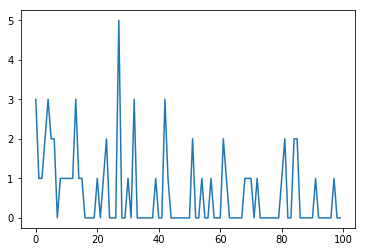

In [16]:
plt.plot((answ_gr > 0).sum(1)[:100])

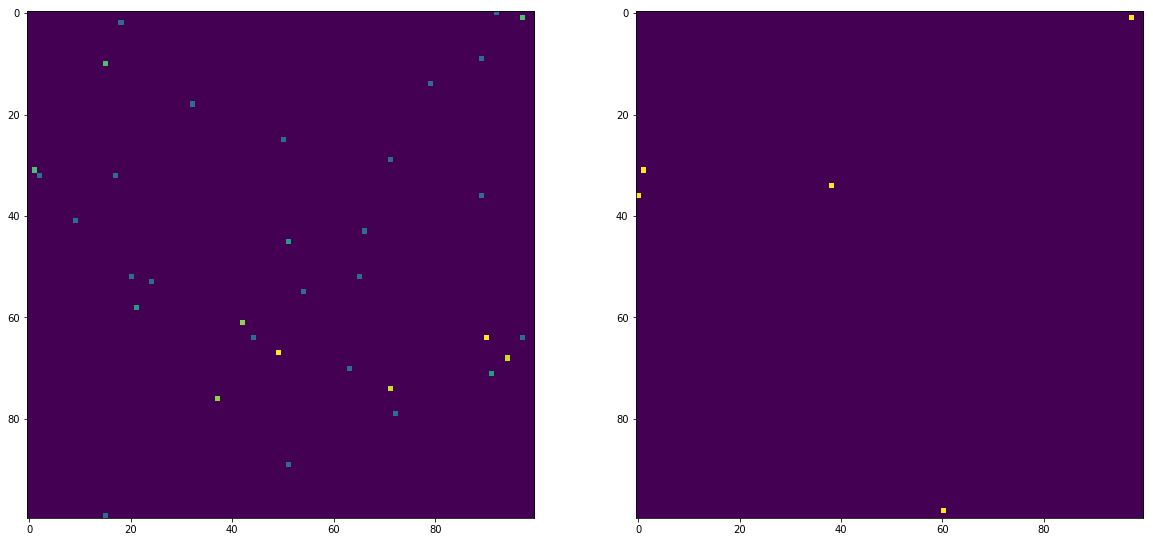

In [21]:
cut1 = 300
cut2 = 400
ca.plot_grs(gr_slv[cut1:cut2, cut1:cut2],
           (answ_gr[cut1:cut2, cut1:cut2] > 0).astype(int),
#             grs_m[1][:cut, :cut],
#             grs_m[2][:cut, :cut],
            log = 1, 
            s = 20)
plt.show()

In [18]:
gb = pickle.load(open("../article/linear_svc_rep_to_rep", 'rb'))

#pred = gb.predict(embs[0]).reshape((grs[0].shape[0] - 1, grs[0].shape[1] - 1))

In [19]:
pred = gb.predict(emb_slv).reshape((gr_slv.shape[0] - 1, gr_slv.shape[1] - 1))

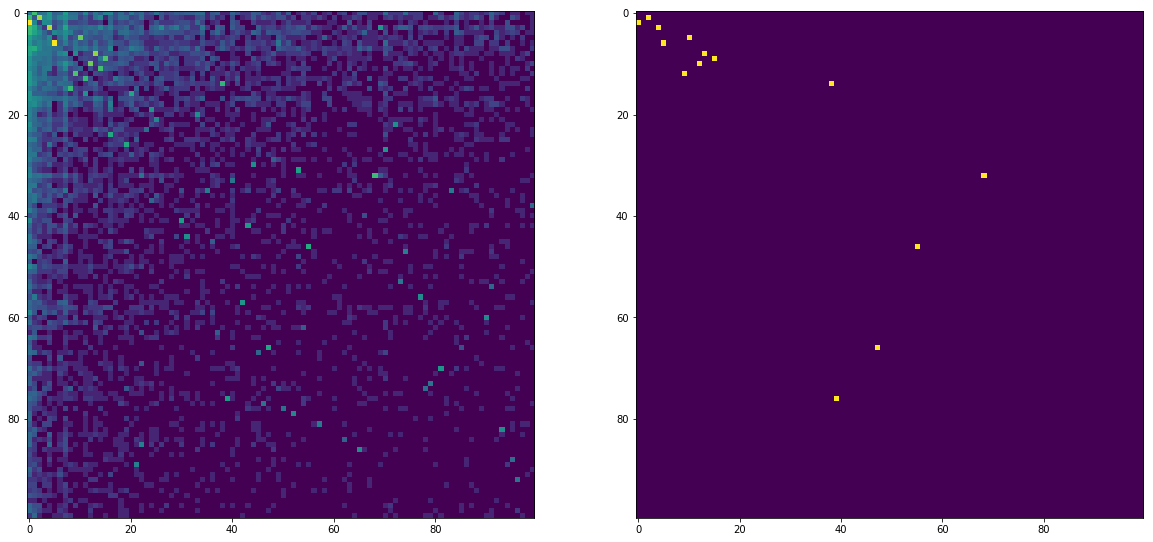

In [20]:
cut = 100
ca.plot_grs(gr_slv[:cut, :cut],
            pred[:cut, :cut],
            log = 1, 
            s = 20, subplots_form = (1,2))
plt.show()

In [18]:
arrs_slv = [x for x in ca.restore_arrays_greedy(gr_slv, 2)[0] if len(x) > 2]

In [19]:
for k,v in a.items():
    if max(d[k]) < 5:
        print(k, d[k])
        for i in ca.print_alignments(ca.water_alignments(v, arrs_slv), v):
            print(i)

first_2 [2, 2, 2, 2, 2]
 32 , 586, 80 , 250, 320,
first_24 [2, 2, 2, 2, 2]
 32 , 586, 80 , 250, 320,
first_61 [2, 2, 2, 2, 2]
 32 , 586, 80 , 250, 320,
first_62 [2, 2, 2, 2, 2]
 32 , 586, 80 , 250, 320,
first_68 [2, 2, 2, 2, 2]
 32 , 586, 80 , 250, 320,
first_5 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 -  , 68 , 6  , 5  , 10 , 334, 338, 12 , 9  , 15 , 8  , 13 ,
 32 , 68 , 6  , 5  , 10 , 12 , 9  , 15 , 8  , 13 , 11 , 14 , 38 , 99 ,
first_50 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 -  , 68 , 6  , 5  , 10 , 334, 338, 12 , 9  , 15 , 8  , 13 ,
 32 , 68 , 6  , 5  , 10 , 12 , 9  , 15 , 8  , 13 , 11 , 14 , 38 , 99 ,
first_8 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 -  , 68 , 6  , 5  , 338, 12 , 9  , 15 , 8  , 13 , 11 , 14 , 38 ,
 32 , 68 , 6  , 5  , 10 , 12 , 9  , 15 , 8  , 13 , 11 , 14 , 38 , 99 ,
first_19 [0, 0, 0, 0, 0, 0, 0, 0]
 85 , 22 , 72 , 219, 225, 139, 51 , 177,
 85 , 22 , 72 , 108, -  , -  , -  , -  ,
 -  , -  , -  , -  , 225, 139, 51 , 223,
first_20 [0, 0, 0, 0, 0, 0, 0, 0]
 85 , 22 , 72 , 219, 225

In [56]:
ca.print_alignments(ca.water_alignments(v, arrs_slv), v)

[' 95 , 36 , 198, 104, 16 ,']

In [54]:
v

[95, 36, 198, 104, 16]